# Investigating the Biodiversity Intactness Index (BII) of Phoenix from 2017 - 2020

By Caitlin Nordheim-Maestas

More information can be found at my Github repository: https://github.com/cnordheim-maestas/phoenix-bii-over-time.git


# About

Biodiversity is incredibly important to healthy environments, and supports human well-being and society, and needs to be protected. Thus, it is vital to track changes in biodiversity to inform land management and conservation efforts. The Phoenix metropolitan area is rapidly expanding and building, and it is important to track biodiversity as these changes occur through time. Here, we will look at declining biodiversity hotspots in in the Phoenix area for 2017 to 2020.

## Purpose

The purpose of this analysis is to compare the Biodiversity Intactness Index (BII) in the Phoenix subdivision in Arizona across time. Specifically, I aim to visualize and compare the loss of area with high BII (greater than or equal to 0.75) from 2017 to 2020. 

## Highlights of analysis 

- Obtain BII Raster data from the Microsoft Planetary Computer
- Create a map with Geographical Context for the Phoenix subdivision using contextilly basemap
- Clip BII raster data to the Phoenix subdivision
- Compare percentage of pixels with high BII across years
- Visualize the change in BII across years in Phoenix by subtracting the rasters
- Create final, well-labeled visualization

## Dataset descriptions

1. Biodiversity Intactness Index Data: 

This data uses 100-meter gridded maps projecting the Biodiversity Intactness Index (BII) in terrestrial biodiversity from 2017 - 2020. The BII is an estimate that incorporates both compositional similarity to a baseline healthy system and abundance of organisms. So, a higher BII is a more intact area of biodiversity. The data is created and curated by Impact Observatory and Vizzuality, and hosted inthe Microsoft Planetary Computer STATC Catalog. I will be using this data for Phoenix, Arizona, and will pull raster data in a relevant spatial bounding box from the MPC STATC Caalog.

2. Phoenix Subdivision Shapefile: 

The US Census Bureau provides shapefiles with outlines of county subdivisions using updated legal boundaries in each state. Here, I will pull the state of Arizona and use the Phoenix shapefile for the analysis. 

## References to datasets

Impact Observatory & Vizzuality (2022). *Biodiversity Intactness* [Data File]. Retrieved from https://planetarycomputer.microsoft.com/dataset/io-biodiversity. Access date: 12.6.2023.

United States Census Bureau, Geography Division (2022). *TIGER/Line Shapefiles County Subdivisions* [Data File]. Retrieved from https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions. Access date: 12.6.2023.


## Contents

1. Data Access & Exploration
2. Geographical context: Phoenix Map
3. Data Manipulation & Analysis: BII in Phoenix
4. Data Visualization: Change in BII hotspots over time
5. Final Output

# 1: Data Access & Exploration

- 1A. Access the catalog and do a spatial search using the bounding box
- 1B. Select and explore 2020 BII data
- 1C. Select and explore 2017 BII data
- 1D. Phoenix polygon: read in and explore

In [1]:
## Load libraries

import numpy as np
import geopandas as gpd
import rioxarray as rioxr
from shapely.geometry import Polygon

# used to access STAC catalogs
from pystac_client import Client
# used to sign items from the MPC STAC catalog
import planetary_computer

import os # accessible file paths

# plotting
import matplotlib.pyplot as plt # for plotting
import matplotlib.patches as mpatches # for pretty legends
from matplotlib import colors

# ----- other libraries for nice ouputs
from IPython.display import Image
import contextily as ctx # for adding basemaps

## 1A: Access the catalog and do a spatial search using the bounding box

In [2]:
# access catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
) # The modifier parameter is needed to access the data in the MPC catalog.

# select and view the collection
biodiv_collection = catalog.get_child('io-biodiversity')
biodiv_collection # explore the io-diversity collection

<CollectionClient id=io-biodiversity>

In [3]:
# Search Spatial range of interest
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# catalog search
search = catalog.search(
    collections=[biodiv_collection], # list with collection id
    bbox=bbox) # include , datetime=time_range to add in the time range
search

# pull the items from the search
items = search.item_collection()

# check it worked, what is the length of our search?
len(items)
items # explore the item

## 1B: Select and explore 2020 BII data

In [4]:
### --- 2020 BII Data exploration
# select 2020 item
item2020 = items[0] # the first one is the 2020 file, indexing starts at 0

# check it worked: print item id and properties
print('id:' , item2020.id)

#print specific properties of interest
print('2020 item start: ', item2020.properties['start_datetime'])
print('2020 item end: ', item2020.properties['start_datetime'])
print('2020 item crs - espg: ', item2020.properties['proj:epsg'])

# Let's explore the item's assets
print('type: ', type(item2020.assets))
print('2020 item assets: ', item2020.assets)

# Asset exploration: 
print('2020 item asset key: ')
for key, asset in item2020.assets.items(): 
    print(key, '-', asset.title)

id: bii_2020_34.74464974521749_-115.38597824385106_cog
2020 item start:  2020-01-01T00:00:00Z
2020 item end:  2020-01-01T00:00:00Z
2020 item crs - espg:  4326
type:  <class 'dict'>
2020 item assets:  {'data': <Asset href=https://pcdata01euw.blob.core.windows.net/impact/bii-v1/bii_2020/bii_2020_34.74464974521749_-115.38597824385106_cog.tif?st=2023-12-05T22%3A04%3A46Z&se=2023-12-13T22%3A04%3A46Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-12-06T22%3A04%3A45Z&ske=2023-12-13T22%3A04%3A45Z&sks=b&skv=2021-06-08&sig=7LEk9m6xgffm%2B37B70Updn6/23EII6Nr1DwXmvjHVqk%3D>, 'tilejson': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/tilejson.json?collection=io-biodiversity&item=bii_2020_34.74464974521749_-115.38597824385106_cog&assets=data&tile_format=png&colormap_name=io-bii&rescale=0%2C1&expression=0.97%2A%28data_b1%2A%2A3.84%29&format=png>, 'rendered_preview': <Asset href=https://planetarycomputer.micr

In [5]:
# pull the data asset and explore
item2020.assets['data']

<Asset href=https://pcdata01euw.blob.core.windows.net/impact/bii-v1/bii_2020/bii_2020_34.74464974521749_-115.38597824385106_cog.tif?st=2023-12-05T22%3A04%3A46Z&se=2023-12-13T22%3A04%3A46Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-12-06T22%3A04%3A45Z&ske=2023-12-13T22%3A04%3A45Z&sks=b&skv=2021-06-08&sig=7LEk9m6xgffm%2B37B70Updn6/23EII6Nr1DwXmvjHVqk%3D>

In [6]:
# Open the 2020 data using the href from the corresponding asset and rioxr.open_rasterio().
# Store it as a variable named data2020
data2020 = rioxr.open_rasterio(item2020.assets['data'].href)
data2020

<xarray.DataArray (band: 1, y: 7992, x: 7992)>
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57 27.57
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [7]:
# exploration
# min and max
print('the rangeof the 2020 BII data is ', data2020.min().item(), ' - ', data2020.max().item())

# nodata
nodata = data2020.rio.nodata
print('the no data values are: (None means no nodata): ', nodata)

the rangeof the 2020 BII data is  0.08015034347772598  -  0.9936537146568298
the no data values are: (None means no nodata):  None


In [8]:
# Data cleaning: Raster reduction

# original dimensions and coordinates
print("2020 Before squeeze:\ndimmensions", {data2020.dims})# confirm dropped
# remove length 1 dimension (band)
data2020 = data2020.squeeze()
# remove coordinates associated to band
data2020 = data2020.drop('band')

print("2020 After squeeze:\ndimmensions", {data2020.dims})# confirm dropped

2020 Before squeeze:
dimmensions {('band', 'y', 'x')}
2020 After squeeze:
dimmensions {('y', 'x')}


2020 data exploratory plot


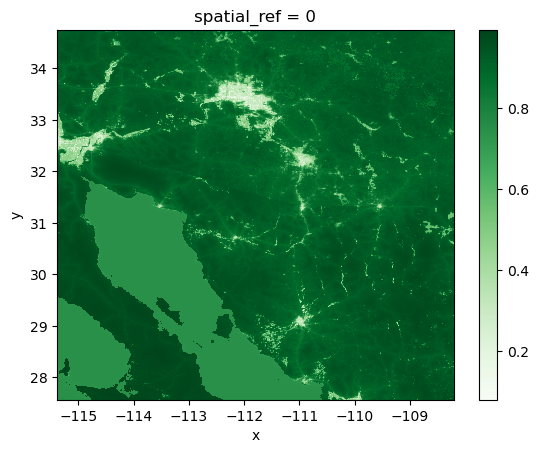

In [9]:
# exploratory plot
print('2020 data exploratory plot')
data2020.plot(cmap='Greens') #I saw the greens on the mpc example and liked it, more green is more intact

## 1C: Select and explore 2017 BII data

In [10]:
# 2017 item
item2017 = items[3] # the fourth one is the 2017 file, indexing starts at 0

# check it worked: print item id and relevant properties
print('id:' , item2017.id)

#print specific properties of interest
print('2017 item start: ', item2017.properties['start_datetime'])
print('2017 item end: ', item2017.properties['start_datetime'])
print('2017 item crs - espg: ', item2017.properties['proj:epsg'])

# Let's explore the item's assets
print('type: ', type(item2017.assets))
print(item2017.assets)

# Asset exploration:
for key, asset in item2017.assets.items(): 
    print(key, '-', asset.title)
    
# pull the data asset and explore
item2017.assets['data']

id: bii_2017_34.74464974521749_-115.38597824385106_cog
2017 item start:  2017-01-01T00:00:00Z
2017 item end:  2017-01-01T00:00:00Z
2017 item crs - espg:  4326
type:  <class 'dict'>
{'data': <Asset href=https://pcdata01euw.blob.core.windows.net/impact/bii-v1/bii_2017/bii_2017_34.74464974521749_-115.38597824385106_cog.tif?st=2023-12-05T22%3A04%3A46Z&se=2023-12-13T22%3A04%3A46Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-12-06T22%3A04%3A45Z&ske=2023-12-13T22%3A04%3A45Z&sks=b&skv=2021-06-08&sig=7LEk9m6xgffm%2B37B70Updn6/23EII6Nr1DwXmvjHVqk%3D>, 'tilejson': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/tilejson.json?collection=io-biodiversity&item=bii_2017_34.74464974521749_-115.38597824385106_cog&assets=data&tile_format=png&colormap_name=io-bii&rescale=0%2C1&expression=0.97%2A%28data_b1%2A%2A3.84%29&format=png>, 'rendered_preview': <Asset href=https://planetarycomputer.microsoft.com/api/data/

<Asset href=https://pcdata01euw.blob.core.windows.net/impact/bii-v1/bii_2017/bii_2017_34.74464974521749_-115.38597824385106_cog.tif?st=2023-12-05T22%3A04%3A46Z&se=2023-12-13T22%3A04%3A46Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-12-06T22%3A04%3A45Z&ske=2023-12-13T22%3A04%3A45Z&sks=b&skv=2021-06-08&sig=7LEk9m6xgffm%2B37B70Updn6/23EII6Nr1DwXmvjHVqk%3D>

In [11]:
# Open the 2017 data using the href from the corresponding asset and rioxr.open_rasterio().
# Store it as a variable named data2017
data2017 = rioxr.open_rasterio(item2017.assets['data'].href)
data2017

<xarray.DataArray (band: 1, y: 7992, x: 7992)>
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57 27.57
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [12]:
# Data cleaning: Raster reduction
# original dimensions and coordinates
print("2017 After squeeze:\ndimmensions", {data2020.dims})# confirm dropped
# remove length 1 dimension (band)
data2017 = data2017.squeeze()
# remove coordinates associated to band
data2017 = data2017.drop('band')
print("2017 After squeeze:\ndimmensions", {data2020.dims})# confirm dropped

2017 After squeeze:
dimmensions {('y', 'x')}
2017 After squeeze:
dimmensions {('y', 'x')}


2017 data exploratory plot


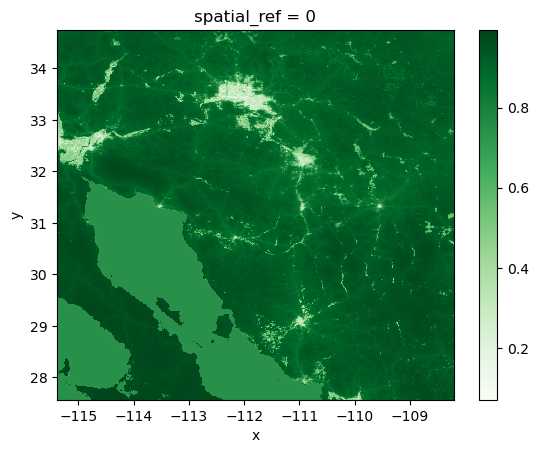

In [13]:
# exploratory plot
print('2017 data exploratory plot')
data2017.plot(cmap='Greens')

## 1D: Phoenix polygon: read in and explore
You will find the Phoenix subdivision polygon in the Census County Subdivision shapefiles for Arizona: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions

In [35]:
# read in data
az_fp = os.path.join(os.getcwd(),'data','tl_2022_04_us_county','tl_2022_04_cousub.shp')
az = gpd.read_file(az_fp) # use gpd to read the file because it's a shapefile
az.columns = az.columns.str.lower() #esnure column names are lowercase
az.head(2) # check it imported by viewing top 2 rows

statefp countyfp cousubfp  cousubns       geoid            name  \
0      04      005    91198  01934931  0400591198       Flagstaff   
1      04      005    91838  01934953  0400591838  Kaibab Plateau   

             namelsad lsad classfp  mtfcc  cnectafp  nectafp  nctadvfp  \
0       Flagstaff CCD   22      Z5  G4040       NaN      NaN       NaN   
1  Kaibab Plateau CCD   22      Z5  G4040       NaN      NaN       NaN   

  funcstat        aland    awater     intptlat      intptlon  \
0        S  12231052883  44653332  +35.1066114  -111.3662497   
1        S   7228864534  29327221  +36.5991097  -112.1368033   

                                            geometry  
0  POLYGON ((-112.13370 35.85596, -112.13368 35.8...  
1  POLYGON ((-112.66039 36.53941, -112.66033 36.5...

['Flagstaff' 'Kaibab Plateau' 'Hualapai' 'Nogales' 'Patagonia' 'Hopi'
 'Tuba City' 'Clifton' 'Duncan' 'Chandler' 'Phoenix'
 'Tonto National Forest' 'Gila Bend' 'Wickenburg' 'Deer Valley' 'Buckeye'
 'St. Johns' 'Salt River' 'Tucson' 'Arivaca' 'Indian Wells'
 'Winslow-Holbrook' 'Snowflake' 'Kayenta' 'Lake Havasu City' 'Fort Apache'
 'Bisbee' 'Bowie' 'Willcox' 'North Mohave' 'Kingman' 'Bullhead City'
 'Congress' 'Mingus Mountain' 'Florence' 'North Pinal' 'San Manuel' 'Eloy'
 'Chinle' 'Sweetwater' 'Fort Defiance' 'Dennehotso' 'Puerco' 'Ash Fork'
 'Cordes Lakes-Mayer' 'Camp Verde-Sedona' 'Prescott' 'Piñon' 'Payson'
 'Winkelman' 'Globe-Miami' 'Tonto Basin' 'Gila River' 'Casa Grande'
 'Maricopa-Stanfield' "Tohono O'odham Nation" 'Coolidge' 'Ajo' 'Marana'
 'Somerton' 'Bonita-Klondyke' 'Eagar-Springerville' 'San Carlos'
 'Havasupai' 'Williams' 'Pima' 'Safford' 'Wellton' 'Yuma' 'Parker'
 'Benson' 'Douglas' 'Sierra Vista' 'Elfrida']
unique names in subset (expecting only Phonix):  ['Phoenix']
pho

<Axes: >

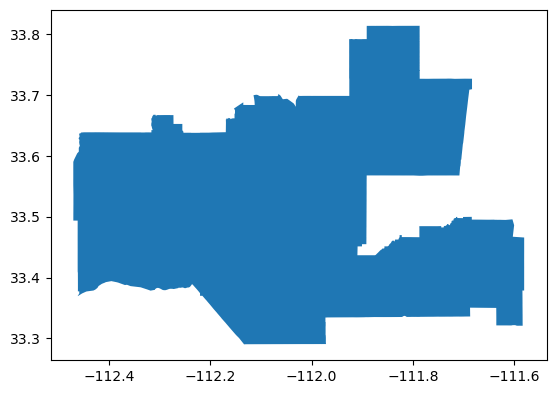

In [15]:
# get list of unique values of counties and look for Phoenix
print(az.name.unique())

# subset only Phoenix
phoenix = az[(az.name=='Phoenix')]
# ensure it worked
print('unique names in subset (expecting only Phonix): ', phoenix.name.unique())

# explore the phoenix shapefile
# print crs
print('phoenix shapefile crs: ', phoenix.crs)

# exploratory plot it
phoenix.plot()

# 2: Geographical context: Phoenix Map

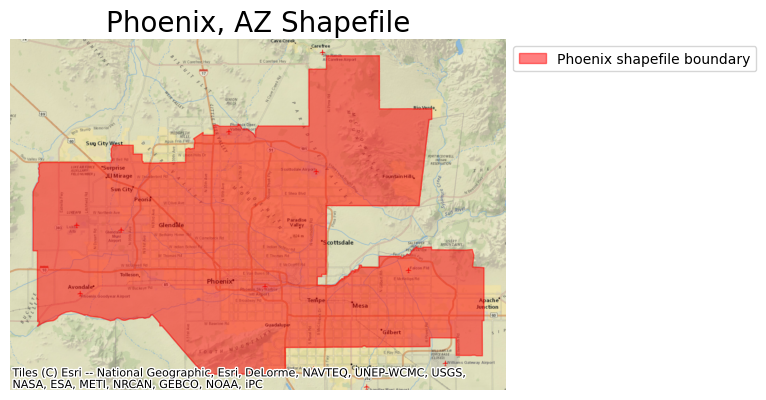

In [16]:
fig, ax=plt.subplots()
ax.axis('off') # remove the pesky box

#----------------------------------
# add the Phoenix Shapefile
(phoenix.to_crs(epsg=3857) #change to epsg 3857, best for contextily
 .plot(ax=ax, figsize=(5,5), alpha=0.5, edgecolor='red', color='red') 
)
# make legend pretty
bbox_patch = mpatches.Patch(color='red', alpha=0.5, label = 'Phoenix shapefile boundary')

#----------------------------------
# add basemap
ctx.add_basemap(ax, source=ctx.providers.Esri.NatGeoWorldMap)

#----------------------------------
# create a legend
ax.legend(handles = [bbox_patch], loc='upper left', bbox_to_anchor=(1,1))

# add a title
ax.set_title('Phoenix, AZ Shapefile', fontsize=20)

plt.show()

# 3 Data Manipulation & Analysis: BII in Phoenix
*Calculate the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017 & 2020*

- 3A: Clip BII data to Phoenix subdivision (first squeeze, reproject, etc) for 2017 and 2020
- 3B: Calculate area of subdivision with BII of at least 0.75 BII in 2017 and 2020
- 3C: Use Raster subtractioon to visualize the difference between 2017 and 2020

## 3A: Reproject and clip BII raster data

In [17]:
# print the CRS of all and match them
print('2020 BII CRS: ', data2020.rio.crs)
print('2017 BII CRS: ', data2017.rio.crs)
print('Phoenix shapefile CRS: ', phoenix.crs)

# change Phoenix crs to the BII crs and check it worked
phoenix_reprojected = phoenix.to_crs(data2020.rio.crs) # change to the BII crs (note 2020 and 2017 are the same)
print('matched crs?',  phoenix_reprojected.crs == data2017.rio.crs) # ensure they match

2020 BII CRS:  EPSG:4326
2017 BII CRS:  EPSG:4326
Phoenix shapefile CRS:  EPSG:4269
matched crs? True


<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x', ylabel='y'>

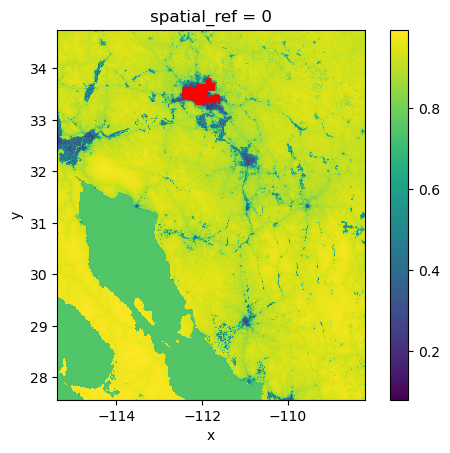

In [18]:
# exploratory plot together to check they are in the same area
fig, ax = plt.subplots()
data2020.plot(ax=ax)
phoenix_reprojected.plot(ax=ax, color='red')

In [19]:
print(type(data2020))
print(type(phoenix_reprojected))

<class 'xarray.core.dataarray.DataArray'>
<class 'geopandas.geodataframe.GeoDataFrame'>


In [20]:
# clip to Phoenix shapefile
data2020_clipped = data2020.rio.clip(phoenix_reprojected.geometry)
data2017_clipped = data2017.rio.clip(phoenix_reprojected.geometry)

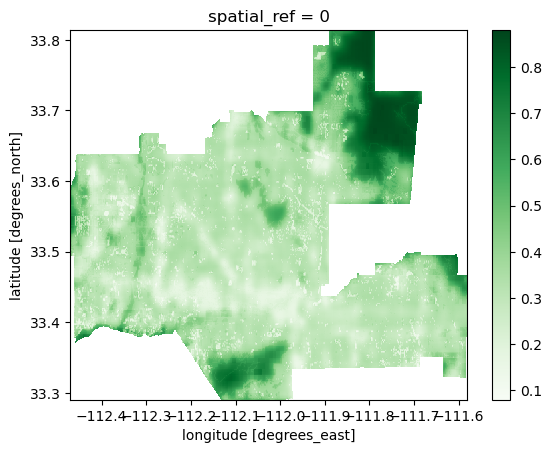

In [21]:
data2020_clipped.plot(cmap='Greens', robust = False)

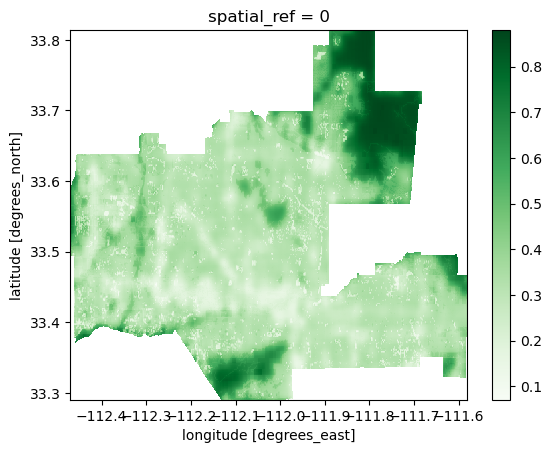

In [22]:
data2017_clipped.plot(cmap='Greens', robust = False)

## 3B: Manipulate rasters and calculate percentages

Step 1: Manipulate raster files by selecting for for BII values x >= 0.75, returning boolean values True and False, then turn the True/False into type ‘int’

Step 2: To calculate the percentage area: (pixels in class)/(total pixels) * 100. 


In [23]:
## Step 1: Manipulate raster files by selecting for for BII values x >= 0.75, returning boolean values True and False, then turn the True/False into type ‘int’
# filter 2017 raster for all at or above 0.75
# This returns a boolean True False for each point
data2017_gr75 = data2017_clipped>=0.75

# convert to integer so it is a 1 if it is bigger than or equal to 0.75 and a 0 if not. 
data2017_gr75 = data2017_gr75.astype(int)

# filter 2020 raster for all above 0.75
# This returns a boolean True False for each point
data2020_gr75 = data2020_clipped>=0.75

# convert to integer so it is a 1 if it is bigger than or equal to 0.75 and a 0 if not. 
data2020_gr75 = data2020_gr75.astype(int)

In [24]:
## Step 2: calculate percentage area: (pixels in class)/(total pixels) * 100

# 2017: sum of all pixels with >= 0.75 bii (aka have a 1) / total pixels (aka the count)
print('The percent of Phoenix area in 2017 with BII >= 0.75 in 2017: ', data2017_gr75.sum().item() / data2017_gr75.count().item() * 100, '%')

# 2020: sum of all pixels with >= 0.75 bii (aka have a 1) / total pixels (aka the count)
print('The percent of Phoenix area in 2020 with BII >= 0.75 in 2020: ', data2020_gr75.sum().item() / data2020_gr75.count().item() * 100, '%')

The percent of Phoenix area in 2017 with BII >= 0.75 in 2017:  4.181263752447286 %
The percent of Phoenix area in 2020 with BII >= 0.75 in 2020:  3.8092762964118023 %


# 4: Data Visualization
*Create a visualization showing the area with BII>=0.75 in 2017 that was lost by 2020.*

- 4A: Use Raster subtraction to visualize the difference between 2017 and 2020
- 4B: Subset only the loss of bii, not the gain too

## 4A: Use Raster subtraction to visualize the difference between 2017 and 2020

In [25]:
data2017_gr75

<xarray.DataArray (y: 583, x: 990)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * x            (x) float64 -112.5 -112.5 -112.5 ... -111.6 -111.6 -111.6
  * y            (y) float64 33.81 33.81 33.81 33.81 ... 33.29 33.29 33.29 33.29
    spatial_ref  int64 0

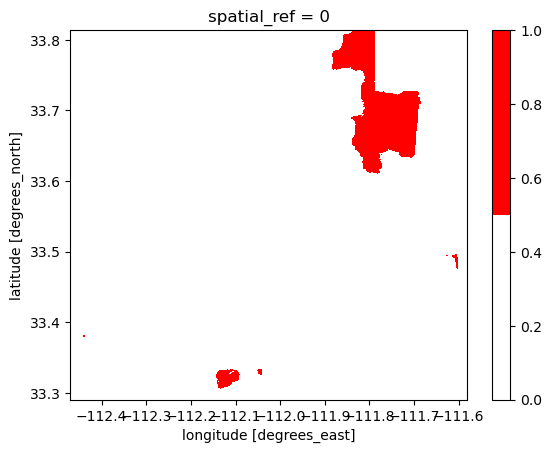

In [26]:
# let's take a look at 2017
mycmap = colors.ListedColormap(['none', 'red'])
data2017_gr75.plot(cmap =mycmap) # the 1's have biodiversity >= 0.75 and the 0's dont!

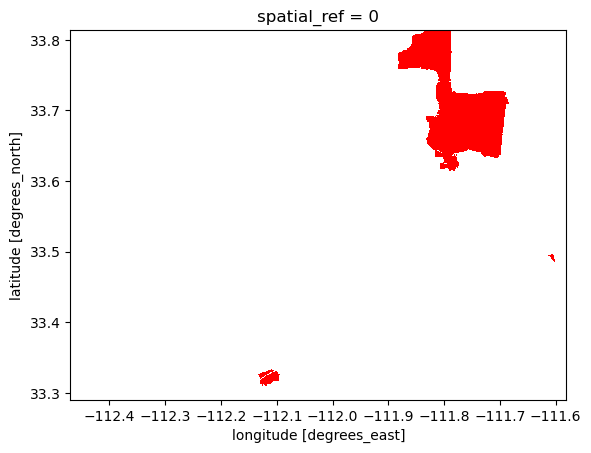

In [27]:
# let's take a look at 2020
mycmap = colors.ListedColormap(['none', 'red'])
data2020_gr75.plot(cmap=mycmap, add_colorbar=False) # the 1's have biodiversity >= 0.75 and the 0's dont!

In [28]:
# raster math: subtract the 2017 from the 2020 raster
diff = data2017_gr75 - data2020_gr75

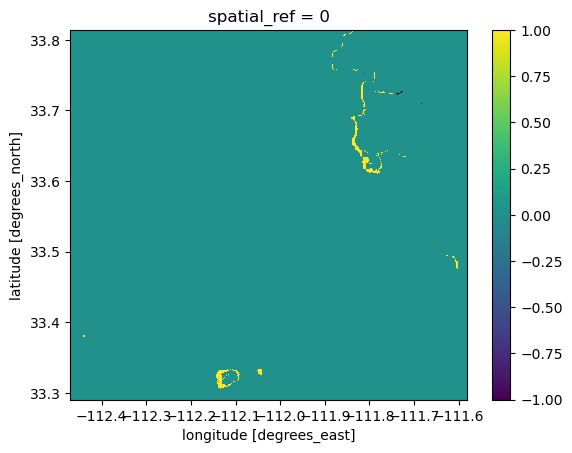

In [29]:
diff.plot(cmap='viridis') # This shows all areas that used to have a BII >=0.75 in 2017 but was lost in 2020! It also shows the gain in blue... we probably want to cut that

Note: now that I did the subtraction, we have positive values (which are a loss of BII >=0.75) in yellow here, which we want to keep. However, if there were areas that gained bii, from 2017 to 2020, they would benegative numbers, and are purple here. I do not want to plot the gains, just the losses, thus I need to only keep the values of "1". 

## 4B: Subset only the loss of bii, not the gain too

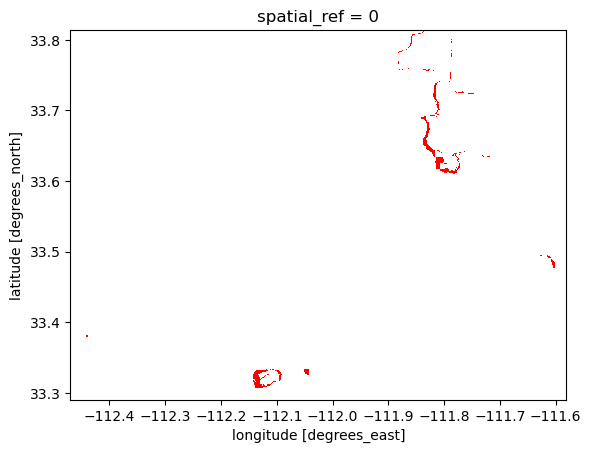

In [30]:
# let's make a map with only 1's and 0's, this will be the difference
diff_map = diff==1
diff_map = diff_map.astype(int)

# remember my colormap
mycmap = colors.ListedColormap(['none', 'red'])

# view
diff_map.plot(cmap=mycmap, add_colorbar=False)

In [31]:
type(data2020_clipped)

xarray.core.dataarray.DataArray

# 5: Final Output

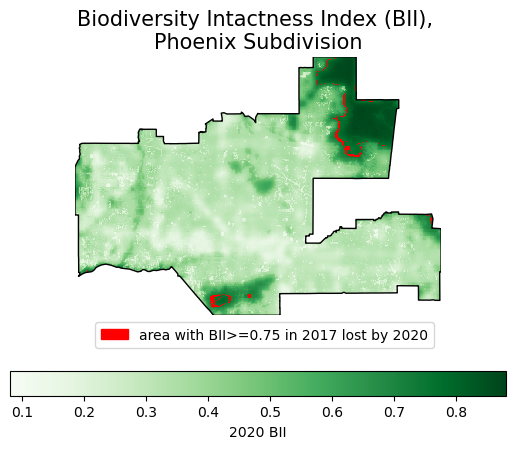

In [33]:
fig, ax=plt.subplots()
ax.axis('off') # remove the pesky box

#----------------------------------
# add the 2020 BII Phoenix data
data2020_clipped.plot(ax=ax, cmap='Greens', cbar_kwargs={"location": "bottom", 'label': "2020 BII"})

#----------------------------------
# remember my colormap
mycmap = colors.ListedColormap(['none', 'red'])

# add the "difference" map showing showing the area with BII>=0.75 in 2017 that was lost by 2020
diff_map.plot(cmap=mycmap, add_colorbar=False)

# make legend pretty using mpatches
bbox_patch = mpatches.Patch(color='red', label = 'area with BII>=0.75 in 2017 lost by 2020')

#----------------------------------
# add the Phoenix Shapefile to allow for an outline
phoenix_reprojected.plot(ax=ax, alpha=1, edgecolor='black', color='none')

#----------------------------------
# create a legend
ax.legend(handles = [bbox_patch], loc='upper right', bbox_to_anchor=(1,0))

# add a title
ax.set_title('Biodiversity Intactness Index (BII), \nPhoenix Subdivision', fontsize=15)

plt.show()